## Load required packages

In [45]:
import os
from collections import Counter
import re
import shutil
import nltk
nltk.download('punkt')
nltk.download('stopwords')
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
nltk.download('wordnet')
from pathlib import Path
nltk.download('wordnet')
nltk.download('omw-1.4')
import stanza
from stanza.utils.conll import CoNLL

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/denisbugaenco/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/denisbugaenco/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/denisbugaenco/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/denisbugaenco/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/denisbugaenco/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [8]:
import stanza

In [9]:
import torch

## Import data 

In [14]:
import os

# Path to the data 
data_dir = '/Users/denisbugaenco/nlp_narrative_classification/data/PT/translated-documents'

# Read each text file and store its contents
documents = []
for filename in os.listdir(data_dir):
    if filename.endswith('.txt'):
        file_path = os.path.join(data_dir, filename)
        with open(file_path, 'r', encoding='utf-8') as file:
            documents.append(file.read())

## Inspect data 

In [15]:
# Load a single file to understand its structure
with open('/Users/denisbugaenco/nlp_narrative_classification/data/PT/translated-documents/PT_01.TXT', 'r', encoding='utf-8') as file:
    sample_text = file.read()
    print(sample_text) 


Climate activists or useful idiots?

"For the liberation of Palestine from the clutches of the Zionist state, for an end to genocide and an end to fossil fuels."

The pinnacle of useful idiotism. Historically, young people have generally always been a mass of maneuvering for certain ideological elites. Social movements are almost always inorganic, almost always artificial, fabricated in universities and then amplified by the "owners" of the narratives and the holders of the dominant instruments in the communication system, in this case the media.

It's no coincidence that social networks are completely attacked in every way, precisely because of this. What social networks have done is to take the monopoly of narratives away from the owners of the communication system.

What is the main objective of these social movements?

The main or only objective, regardless of whether the activists are aware or not - some are aware, others have no idea - is that they believe they are defending very

We can oberve that the topic of the documents (CC or URW) are not inidcated in the file name as for the EN documents

We change the name of the documents adding also the topic for better intepretability 

Load and parse the annotations to determine which topic each file belongs to

In [16]:
annotations_path = '/Users/denisbugaenco/nlp_narrative_classification/data/PT/subtask-2-annotations.txt'
topic_mapping = {}

with open(annotations_path, 'r', encoding='utf-8') as file:
    for line in file:
        parts = line.strip().split('\t')
        file_name, topic_info = parts[0], parts[1]
        if 'CC' in topic_info:
            topic_mapping[file_name] = 'CC'
        elif 'URW' in topic_info:
            topic_mapping[file_name] = 'URW'

print(topic_mapping)


{'PT_161.txt': 'CC', 'PT_13.txt': 'URW', 'PT_153.txt': 'CC', 'PT_196.txt': 'CC', 'PT_56.txt': 'CC', 'PT_21.txt': 'URW', 'PT_99.txt': 'URW', 'PT_64.txt': 'URW', 'PT_117.txt': 'CC', 'PT_72.txt': 'URW', 'PT_168.txt': 'CC', 'PT_41.txt': 'URW', 'PT_84.txt': 'URW', 'PT_125.txt': 'URW', 'PT_137.txt': 'CC', 'PT_17.txt': 'URW', 'PT_110.txt': 'URW', 'PT_79.txt': 'URW', 'PT_141.txt': 'CC', 'PT_48.txt': 'URW', 'PT_05.txt': 'URW', 'PT_184.txt': 'CC', 'PT_60.txt': 'CC', 'PT_149.txt': 'CC', 'PT_156.txt': 'CC', 'PT_181.txt': 'CC', 'PT_28.txt': 'URW', 'PT_113.txt': 'URW', 'PT_121.txt': 'URW', 'PT_37.txt': 'URW', 'PT_173.txt': 'CC', 'PT_199.txt': 'CC', 'PT_130.txt': 'URW', 'PT_92.txt': 'URW', 'PT_02.txt': 'URW', 'PT_109.txt': 'URW', 'PT_45.txt': 'URW', 'PT_88.txt': 'URW', 'PT_32.txt': 'URW', 'PT_09.txt': 'URW', 'PT_128.txt': 'URW', 'PT_188.txt': 'CC', 'PT_145.txt': 'CC', 'PT_65.txt': 'URW', 'PT_22.txt': 'URW', 'PT_136.txt': 'CC', 'PT_152.txt': 'CC', 'PT_49.txt': 'URW', 'PT_06.txt': 'URW', 'PT_170.txt': 

In [17]:


# Path to the data
data_dir

# Path to the annotations
annotations_path = '/Users/denisbugaenco/nlp_narrative_classification/data/PT/subtask-2-annotations.txt'

# Load topic annotations
topic_mapping = {}
with open(annotations_path, 'r', encoding='utf-8') as file:
    for line in file:
        parts = line.strip().split('\t')
        file_name, topic_info = parts[0], parts[1]
        if 'CC' in topic_info:
            topic_mapping[file_name] = 'CC'
        elif 'URW' in topic_info:
            topic_mapping[file_name] = 'URW'

# Read each text file and store its contents in a dictionary with new names based on topic
documents = {}
for filename in os.listdir(data_dir):
    if filename.endswith('.txt'):
        # Extract the number from the filename assuming format 'PT_XX.txt'
        number = filename.split('_')[1].split('.txt')[0]
        # Create new filename with format 'PT_TOPIC_XX.txt'
        new_filename = f'PT_{topic_mapping.get(filename, "Unknown")}_{number}.txt'
        file_path = os.path.join(data_dir, filename)
        with open(file_path, 'r', encoding='utf-8') as file:
            documents[new_filename] = file.read()

# Now, documents is a dictionary where keys are filenames with topics, and values are the file contents
print(list(documents.keys()))  # To see the new filenames


['PT_CC_53.txt', 'PT_URW_47.txt', 'PT_URW_90.txt', 'PT_URW_84.txt', 'PT_CC_166.txt', 'PT_Unknown_172.txt', 'PT_CC_199.txt', 'PT_CC_198.txt', 'PT_CC_173.txt', 'PT_CC_167.txt', 'PT_URW_85.txt', 'PT_URW_91.txt', 'PT_URW_46.txt', 'PT_CC_52.txt', 'PT_URW_44.txt', 'PT_URW_50.txt', 'PT_URW_78.txt', 'PT_URW_87.txt', 'PT_URW_93.txt', 'PT_CC_171.txt', 'PT_CC_165.txt', 'PT_CC_159.txt', 'PT_CC_158.txt', 'PT_Unknown_164.txt', 'PT_CC_170.txt', 'PT_URW_92.txt', 'PT_CC_86.txt', 'PT_URW_79.txt', 'PT_CC_51.txt', 'PT_URW_45.txt', 'PT_Unknown_69.txt', 'PT_URW_41.txt', 'PT_CC_55.txt', 'PT_Unknown_82.txt', 'PT_URW_96.txt', 'PT_CC_148.txt', 'PT_CC_174.txt', 'PT_Unknown_160.txt', 'PT_CC_161.txt', 'PT_CC_175.txt', 'PT_CC_149.txt', 'PT_CC_97.txt', 'PT_URW_83.txt', 'PT_URW_54.txt', 'PT_URW_40.txt', 'PT_URW_68.txt', 'PT_CC_56.txt', 'PT_URW_42.txt', 'PT_URW_95.txt', 'PT_URW_81.txt', 'PT_CC_163.txt', 'PT_CC_177.txt', 'PT_CC_188.txt', 'PT_CC_189.txt', 'PT_CC_176.txt', 'PT_CC_162.txt', 'PT_CC_200.txt', 'PT_URW_80.txt

Inspect the topcis and look for no topics assigned 

In [18]:
# Initialize counters for each topic
count_cc = 0
count_ua = 0
count_unknown = 0

# Iterate through the filenames in the documents dictionary to count topics
for filename in documents.keys():
    topic = filename.split('_')[1]  # This assumes the filename format is 'PT_TOPIC_XX.txt'
    if topic == 'CC':
        count_cc += 1
    elif topic == 'URW':
        count_ua += 1
    else:
        count_unknown += 1  # Assume any filename not having 'CC' or 'UA' as topic is unknown

# Print the counts
print("Number of files with Climate Change (CC) topic:", count_cc)
print("Number of files with Ukraine War (URW) topic:", count_ua)
print("Number of files without a recognized topic:", count_unknown)


Number of files with Climate Change (CC) topic: 77
Number of files with Ukraine War (URW) topic: 107
Number of files without a recognized topic: 16


There are 16 docuemnt with unregonzied topic

We manually inpsect the 16 documents to assign a topic 

In [19]:
# Filter and print documents with an 'Unknown' topic for manual inspection
unknown_documents = {filename: documents[filename] for filename in documents if 'Unknown' in filename}

for filename, content in unknown_documents.items():
    print(f"Filename: {filename}\nContent: {content[:500]}...\n")  # Print the first 500 characters to get an idea of the content


Filename: PT_Unknown_172.txt
Content: King Charles installs solar panels at Windsor Castle

King Charles III of the United Kingdom, who has campaigned on environmental issues throughout his life, has installed solar panels at Windsor Castle and plans to convert the British royal family's Bentley cars to run on biofuel, palace officials said.

Charles installed solar panels on part of the Windsor Castle estate known as the Lord Chamberlain's Upper Store, replacing the existing lead roof. The plan is to add more panels in the future, ...

Filename: PT_Unknown_164.txt
Content: Portugal must demand the release of Captain Paul Watson, the whale protector

Captain Paul Watson has been tirelessly traveling the world's seas for decades to defend whales. The founder of Sea Shepherd does nothing more than enforce the law, since whales are supposed to be protected by international law. Whaling has been officially banned since a moratorium adopted by the International Whaling Commission (IWC) came

For now we don't proceed to change them since the annotations file provided also contain them for the training part. 

### Most frequents words

In [20]:
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# Define stop words
stop_words = set(stopwords.words('english'))

# Initialize dictionary to store word counts by topic
topic_word_counts = {
    'CC': Counter(),
    'URW': Counter(),
    'Unknown': Counter()
}

# Process each document based on topic
for filename, content in documents.items():
    topic = filename.split('_')[1]  # Extract the topic from filename (e.g., 'CC', 'URW', 'Unknown')
    tokens = word_tokenize(content.lower())
    filtered_tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    topic_word_counts[topic].update(filtered_tokens)

# Print the most common words for each category
for topic, counter in topic_word_counts.items():
    print(f"Most common words for topic {topic}:")
    for word, freq in counter.most_common(30):
        print(f"{word}: {freq}")
    print("\n")  # Add spacing between topics for readability


Most common words for topic CC:
climate: 255
change: 141
people: 91
also: 85
said: 82
temperatures: 71
world: 70
according: 68
years: 65
year: 60
heat: 59
new: 57
global: 56
water: 55
could: 53
brazil: 53
last: 53
country: 50
temperature: 50
fires: 46
time: 44
extreme: 44
one: 44
due: 43
environmental: 42
group: 39
amazon: 39
says: 39
government: 38
study: 38


Most common words for topic URW:
ukraine: 432
russia: 336
russian: 326
said: 282
ukrainian: 249
nato: 145
us: 143
president: 141
military: 141
kiev: 128
war: 114
moscow: 113
according: 111
also: 108
zelensky: 100
would: 96
countries: 92
security: 86
minister: 84
western: 84
defense: 82
forces: 79
conflict: 78
west: 77
putin: 75
country: 74
foreign: 73
european: 71
weapons: 64
states: 62


Most common words for topic Unknown:
russian: 34
ukraine: 26
ukrainian: 23
said: 17
climate: 16
since: 15
also: 15
change: 14
according: 13
country: 12
global: 11
russia: 11
million: 10
president: 10
military: 10
people: 10
forces: 10
heat: 10


We visualize the most rappresenitng words 

We remove some  unuseful words just for a better vizualization and to see a general lanscape of each topic 

In [21]:
# Additional common words to exclude (domain-specific stopwords)
additional_stopwords = {'said', 'also', 'according', 'year', 'years', 'us', 'new'}

# Combine with NLTK stopwords
all_stopwords = stop_words.union(additional_stopwords)

# Initialize counters for each topic
word_counts = {
    'CC': Counter(),
    'URW': Counter(),
    'Unknown': Counter()
}
# Process each document and count words based on topic
for filename, content in documents.items():
    topic = filename.split('_')[1]  # Get the topic from the filename
    text = content.lower()
    tokens = word_tokenize(text)
    # Filter out stopwords and non-alphabetic tokens
    filtered_tokens = [word for word in tokens if word.isalpha() and word not in all_stopwords]
    # Update the Counter for the appropriate topic
    word_counts[topic].update(filtered_tokens)

In [28]:
from nltk.corpus import stopwords
from collections import Counter
from nltk.tokenize import word_tokenize

# Define stopwords and additional common words to exclude
stop_words = set(stopwords.words('english'))
additional_stopwords = {'said', 'also', 'according', 'year', 'years', 'us', 'new'}
all_stopwords = stop_words.union(additional_stopwords)

# Initialize counters for each topic
word_counts = {
    'CC': Counter(),
    'URW': Counter(),
    'Unknown': Counter()
}

# Process each document and count words based on topic
for filename, content in documents.items():
    topic = filename.split('_')[1]  # Get the topic from the filename
    text = content.lower()
    tokens = word_tokenize(text)
    # Filter out stopwords and non-alphabetic tokens
    filtered_tokens = [word for word in tokens if word.isalpha() and word not in all_stopwords]
    # Update the Counter for the appropriate topic
    word_counts[topic].update(filtered_tokens)

# Display the most common words for each topic
for topic, counter in word_counts.items():
    print(f"Most frequent words in {topic}:", counter.most_common(30))


Most frequent words in CC: [('climate', 255), ('change', 141), ('people', 91), ('temperatures', 71), ('world', 70), ('heat', 59), ('global', 56), ('water', 55), ('could', 53), ('brazil', 53), ('last', 53), ('country', 50), ('temperature', 50), ('fires', 46), ('time', 44), ('extreme', 44), ('one', 44), ('due', 43), ('environmental', 42), ('group', 39), ('amazon', 39), ('says', 39), ('government', 38), ('study', 38), ('since', 38), ('record', 37), ('planet', 35), ('president', 35), ('already', 34), ('million', 34)]
Most frequent words in URW: [('ukraine', 432), ('russia', 336), ('russian', 326), ('ukrainian', 249), ('nato', 145), ('president', 141), ('military', 141), ('kiev', 128), ('war', 114), ('moscow', 113), ('zelensky', 100), ('would', 96), ('countries', 92), ('security', 86), ('minister', 84), ('western', 84), ('defense', 82), ('forces', 79), ('conflict', 78), ('west', 77), ('putin', 75), ('country', 74), ('foreign', 73), ('european', 71), ('weapons', 64), ('states', 62), ('since'

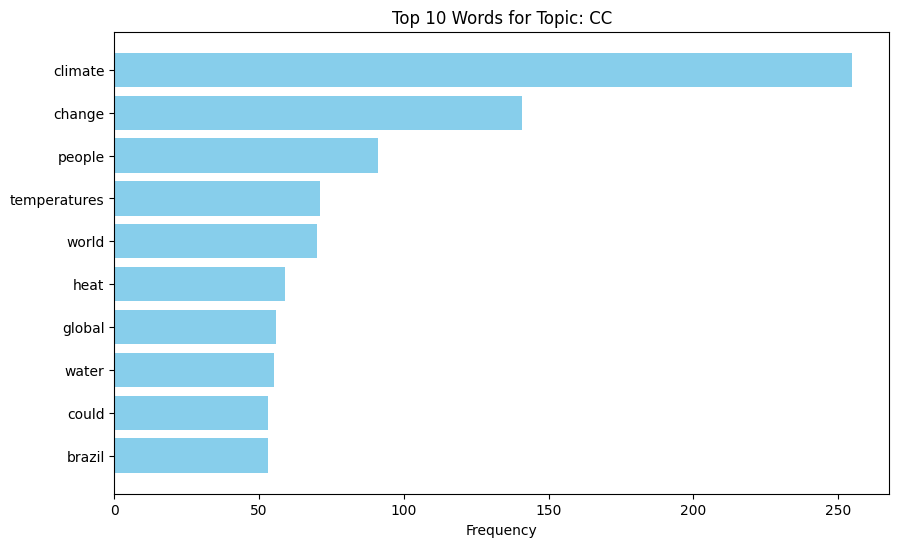

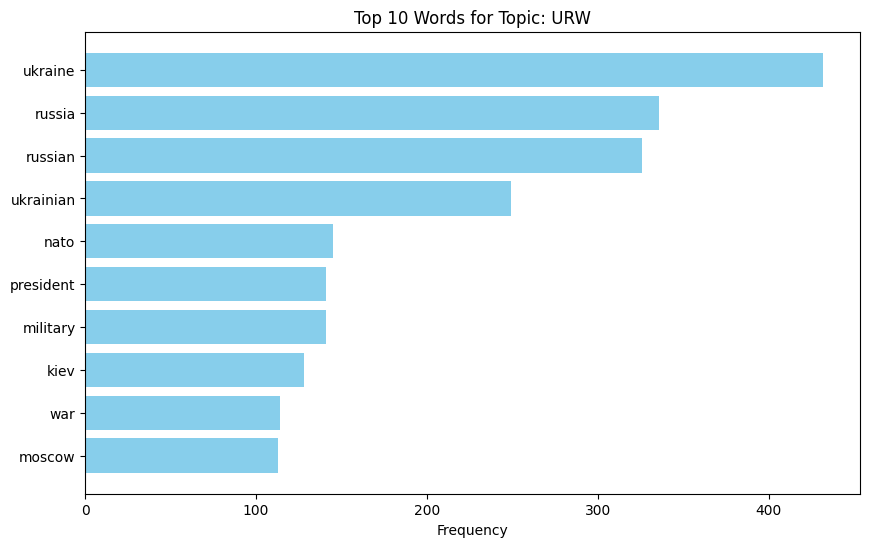

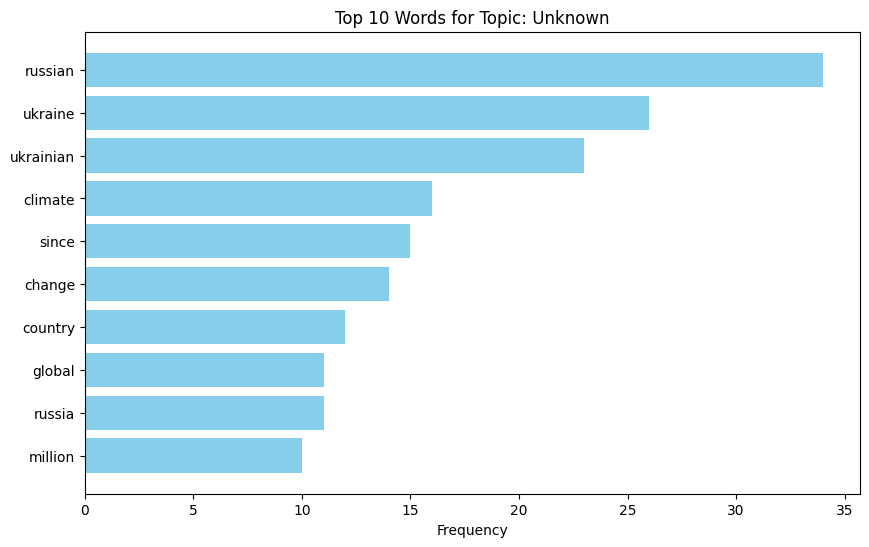

In [29]:
# Plot the most common words for each topic
for topic, counter in word_counts.items():
    common_words = counter.most_common(10)
    words, counts = zip(*common_words)  # Separate words and counts for plotting
    plt.figure(figsize=(10, 6))
    plt.barh(words, counts, color='skyblue')
    plt.xlabel('Frequency')
    plt.title(f'Top 10 Words for Topic: {topic}')
    plt.gca().invert_yaxis()  # Invert y-axis for better readability
    plt.show()

### Boilerplate analysis 

We inspect the documents to tdentify phrases or sentences that appear frequently across multiple documents without giving any additional and relevant value to the document. (Ex: Share on Instagram)
We use sentences based tokenization for this task.

In [30]:
from collections import Counter
from nltk.tokenize import sent_tokenize

# Initialize a Counter to track sentence frequencies across all documents
sentence_freq = Counter()

# Process each document to count sentence frequencies
for content in documents.values():
    sentences = sent_tokenize(content.lower())  # Tokenize into sentences
    sentence_freq.update(sentences)

# Display sentences that appear more than once (potential boilerplate)
boilerplate_candidates = {sentence: freq for sentence, freq in sentence_freq.items() if freq > 1}
print("Potential boilerplate sentences:\n")
for sentence, freq in boilerplate_candidates.items():
    print(f"{sentence}: {freq} times")


Potential boilerplate sentences:

the russian military offensive on ukrainian territory, launched on february 24, 2022, plunged europe into what is considered the most serious security crisis since the second world war (1939-1945).: 2 times
ukraine has been relying on financial and arms aid from the western allies, who have also enacted sanctions against key sectors of the russian economy in an attempt to reduce moscow's ability to finance the war effort.: 4 times
russia restricts civilian access to villages in border region bombed by ukraine

access to 14 villages in the belgorod region of southern russia, on the border with ukraine, will be closed to most civilians, governor vyacheslav gladkov said on tuesday, citing the "extremely difficult" situation due to ukrainian shelling.: 2 times
announcing the new restrictions in a video posted on his telegram channel, gladkov said that from next week, only adult men accompanying military or government officials will be allowed to enter the 

The documents don't posses Boilerplates sentences.

## Text normalization and lemmatization

Normalization

In [46]:

# Define stopwords
stop_words = set(stopwords.words('english'))
additional_stopwords = {} # If necessary in the futture to add other stopwords
all_stopwords = stop_words.union(additional_stopwords)

# Function to normalize text
def normalize_text(text):
    # Lowercase
    text = text.lower()
    # Tokenize
    tokens = word_tokenize(text)
    # Remove punctuation, numbers, and stopwords
    normalized_tokens = [
        word for word in tokens 
        if word.isalpha() and word not in all_stopwords
    ]
    return normalized_tokens

# Apply normalization to each document in the dataset
normalized_documents = {filename: normalize_text(content) for filename, content in documents.items()}

# Check normalized output for a sample document
for filename, words in normalized_documents.items():
    print(f"Normalized words in {filename}:", words[:20])  # View first 20 normalized words
    break

Normalized words in PT_CC_53.txt: ['scientists', 'deny', 'climate', 'emergency', 'already', 'scientists', 'including', 'several', 'nobel', 'laureates', 'signed', 'declaration', 'entitled', 'climate', 'emergency', 'text', 'promoted', 'climate', 'intelligence', 'foundation']


Lemmatization

In [10]:
# Initialize the Stanza pipeline for English with lemmatization
stanza.download('en') 
nlp = stanza.Pipeline('en', processors='tokenize,lemma')

2024-11-06 15:00:03 INFO: Downloaded file to /Users/denisbugaenco/stanza_resources/resources.json
2024-11-06 15:00:03 INFO: Downloading default packages for language: en (English) ...
2024-11-06 15:00:04 INFO: File exists: /Users/denisbugaenco/stanza_resources/en/default.zip
2024-11-06 15:00:08 INFO: Finished downloading models and saved to /Users/denisbugaenco/stanza_resources


In [47]:
# Function to lemmatize text using Stanza
def lemmatize_text(tokens):
    # Join the tokens back into a single string for Stanza processing
    text = " ".join(tokens)
    # Use Stanza to process the text and lemmatize it
    doc = nlp(text)
    # Extract lemmas from the processed document
    lemmatized_text = " ".join([word.lemma for sentence in doc.sentences for word in sentence.words])
    return lemmatized_text

# Apply lemmatization to each normalized document
lemmatized_documents = {filename: lemmatize_text(words) for filename, words in normalized_documents.items()}

# Display an example of lemmatized output
for filename, lemmatized_content in lemmatized_documents.items():
    print(f"Lemmatized content of {filename}:\n{lemmatized_content[:200]}...\n")
    break  # Print only the first document as an example

Lemmatized content of PT_CC_53.txt:
scientist deny climate emergency already scientist include several nobel laureate sign declaration entitle climate emergency text promote climate intelligence foundation clintel climate science less p...




## The CoNLL format

In [49]:

# Set the output directory to the desired path
output_directory = "/Users/denisbugaenco/Desktop/NLP"
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Write lemmatized documents to CoNLL-U format and display output for an example document
for filename, content in normalized_documents.items():
    # Get the Stanza document and the lemmatized text
    doc, lemmatized_content = lemmatize_text(content)

    # Define output file name
    output_file = os.path.join(output_directory, f"output_{filename}.conllu")

    # Write to CoNLL-U format
    CoNLL.write_doc2conll(doc, output_file)

    # Display the CoNLL output for the first document as an example
    with open(output_file) as f:
        print(f"CoNLL format content of {filename}:")
        print(''.join(f.readlines()))
        print("\n")
    break  # Print only the first document as an example


CoNLL format content of PT_CC_53.txt:
# text = scientists deny climate emergency already scientists including several nobel laureates signed declaration entitled climate emergency text promoted climate intelligence foundation clintel climate science less political climate policy scientific text states climate emergency therefore reason panic alarm strongly oppose damaging unrealistic net zero policy proposed bet adaptation instead mitigation adaptation works regardless causes said group scientists argue gas essential planet also argue earth climate varied long planet existed planet gone several cold hot phases two nobel prize winners american physicists ivar giaever john clauser nobel prize winners respectively joined declaration climate change crisis said popular narrative climate change reflects dangerous corruption science threatens global economy billions people spaniard among signatories majorcan luis pomar geologist professor emeritus university balearic islands list scientists r

In [ ]:
import os
from stanza.utils.conll import CoNLL

# Set the output directory to the desired path
output_directory = "/Users/denisbugaenco/Desktop/NLP/pt_output_CoNLL"
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Write lemmatized documents to CoNLL-U format and display output for all documents
for filename, content in normalized_documents.items():
    # Get the Stanza document and the lemmatized text
    doc, lemmatized_content = lemmatize_text(content)

    # Define output file name
    output_file = os.path.join(output_directory, f"output_{filename}.conllu")

    # Write to CoNLL-U format
    CoNLL.write_doc2conll(doc, output_file)

    # Display the CoNLL output for each document
    with open(output_file) as f:
        print(f"CoNLL format content of {filename}:")
        print(''.join(f.readlines()))
        print("\n")

# No break statement to ensure all files are processed and saved


CoNLL format content of PT_CC_53.txt:
# text = scientists deny climate emergency already scientists including several nobel laureates signed declaration entitled climate emergency text promoted climate intelligence foundation clintel climate science less political climate policy scientific text states climate emergency therefore reason panic alarm strongly oppose damaging unrealistic net zero policy proposed bet adaptation instead mitigation adaptation works regardless causes said group scientists argue gas essential planet also argue earth climate varied long planet existed planet gone several cold hot phases two nobel prize winners american physicists ivar giaever john clauser nobel prize winners respectively joined declaration climate change crisis said popular narrative climate change reflects dangerous corruption science threatens global economy billions people spaniard among signatories majorcan luis pomar geologist professor emeritus university balearic islands list scientists r

Inspect documents

In [57]:
# Define the output directory and filename to access
output_directory = "/Users/denisbugaenco/Desktop/NLP/pt_output_CoNLL"
specific_filename = "output_PT_CC_53.txt.conllu"  # Replace with the actual file you want to acces
file_path = os.path.join(output_directory, specific_filename)

In [58]:

if os.path.exists(file_path):
    with open(file_path, 'r') as f:
        content = f.read()
        print(f"Contents of {specific_filename}:\n")
        print(content)
else:
    print(f"File {specific_filename} does not exist.")

Contents of output_PT_CC_53.txt.conllu:

# text = scientists deny climate emergency already scientists including several nobel laureates signed declaration entitled climate emergency text promoted climate intelligence foundation clintel climate science less political climate policy scientific text states climate emergency therefore reason panic alarm strongly oppose damaging unrealistic net zero policy proposed bet adaptation instead mitigation adaptation works regardless causes said group scientists argue gas essential planet also argue earth climate varied long planet existed planet gone several cold hot phases two nobel prize winners american physicists ivar giaever john clauser nobel prize winners respectively joined declaration climate change crisis said popular narrative climate change reflects dangerous corruption science threatens global economy billions people spaniard among signatories majorcan luis pomar geologist professor emeritus university balearic islands list scientist